# Very Simple Model

First, we don't model:
- the errors on the observables
- from IPython.core.display import display, HTMLthe halo mass function

In [1]:
from IPython.core.display import display, HTML

Modifications: Johnny Esteves

Author: Allen Pinjic - Created on June 21st, 2022

In [2]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as plt
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math
import os
import sys
import emcee
import pandas as pd

In [4]:
%matplotlib inline

# Creating an MCMC Model

In [5]:
df = pd.read_csv('fake_data_Jun21.csv')
df

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.316481,1.587627e+14,50.701638,2.852264,42.046416,2.123088
1,0.271402,1.365134e+14,28.244616,1.673184,35.791641,1.665205
2,0.356016,7.694109e+14,306.196703,29.580211,211.632753,24.142014
3,0.641366,1.710156e+14,49.448419,2.806810,47.863622,2.593742
4,0.321785,3.659995e+14,91.881499,8.352681,98.646153,7.655673
...,...,...,...,...,...,...
995,0.641944,1.372731e+14,36.894000,1.814944,38.255049,1.851715
996,0.913352,1.363414e+14,59.701825,2.557670,39.776608,1.972583
997,0.266486,1.009999e+14,28.243455,1.157683,26.301498,1.047632
998,0.169713,1.355374e+14,39.018022,1.537474,34.991528,1.607091


In [6]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

In [7]:
mask = (df['lambda']>5)&(df['zeta']>3)
ix = np.where(mask)[0]
Np = ix.size

## changin here
yerr = 0.05*(df['lambda'].to_numpy())

redshift = (np.array(df['z']))[ix]
sz_signal = (np.array(df['zeta']))[ix]
_lambda = (np.array(df['lambda']))[ix]
_lambda_error = (np.array(yerr))[ix]
mass = np.array(df['M'])[ix]

print('Number of points',Np)

Number of points 318


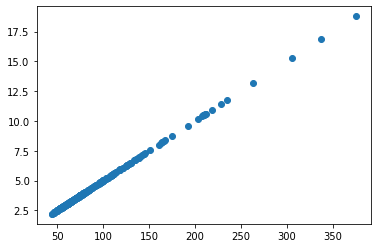

In [8]:
# plt.loglog()
plt.scatter(_lambda, _lambda_error)

In [9]:
# set up integration vectors
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), 100)
mvec = np.logspace(13.8, 15.2, 75)
lbdvec = np.linspace(3, 1.2*np.max(np.array(df['lambda'])), 150)
zetavec = np.linspace(1, 1.1*np.max(np.array(df['zeta'])), 75)

print('Vector size')
print(lbdvec.size)
print(zetavec.size)

Vector size
150
75


In [10]:
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
Nburnin = 1000 # number of burn-in samples
Nsamples = 5000 # number of final posterior samples
walkers = 32
ndims = len(theta_true)

guess = (np.array(theta_true)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

In [11]:
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

M0 = 3e14
Ez0 = E(0)

In [12]:
# mmm had a shape (Ncls,300,150)

In [13]:
def log_likelihood_very_simple(theta):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
        
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass, redshift)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, redshift)
        
    # compute dn_dlbd_dzeta_integrand
    # Now p_lbd_zeta instead of p_total_m = compute_dn_dlbd_dzeta_vec2
    lp_lbd_zeta = compute_log_pLbdZeta(_lambda, sz_signal,
                                       scatter_lambda, scatter_sze, rho,
                                       ln_lbd_pred, ln_zeta_pred)
    return np.nansum(lp_lbd_zeta)

def compute_log_pLbdZeta(Lambda, Zeta, scatter_lambda, scatter_sze, rho,
                         ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = scatter_sze#logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = scatter_lambda#logNormal_variance(ln_lbd_pred, scatter_lambda)
    
    s_lambda_inv = np.where(s_lambda<=eps, np.inf, 1/s_lambda)
    s_zeta_inv = np.where(s_zeta<=eps, np.inf, 1/s_zeta)
    
    # avoid error messages
    rho2 = (1-rho**2)
    rho_inv = np.where(rho2<=eps, np.inf, 1/rho2)
    
    cov2 = (s_lambda)**(2)*(s_zeta)**(2)*rho2
    additional_cov = (-0.5)*np.log(np.pi*cov2)
        
    lbd_std = (np.log(Lambda) - ln_lbd_pred)*s_lambda_inv
    zeta_std = (np.log(Zeta) - ln_zeta_pred)*s_zeta_inv
    #np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2.

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    
    # total likelihood
    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    # logNomral term
    #lp_total_m += -np.log(Lambda)-np.log(Zeta)
    return lp_total_m

# Checking the Log Likelihood Function

In [14]:
log_likelihood_very_simple(theta_true)

725.3610428162804

In [15]:
# a quick of 10% from the truth
initial = theta_true + 0.2 * np.random.randn(9)
log_likelihood_very_simple(initial)

-226896.03963111073

In [16]:
## plotting this results
np.random.seed(42)
lps = [-1.*log_likelihood_very_simple(theta_true)]
dist = [0.]
# increase the quick from the truth
for i in [1.,5.,10.,15.,20.,25.,30.,60]:
    initial = theta_true + (i/100.) * np.random.randn(9)
    nDist = np.linalg.norm(np.array(theta_true)-np.array(initial))
    lps.append(-1.*log_likelihood_very_simple(initial))
    dist.append(nDist)

<ipython-input-13-5508ea45f026>:48: RuntimeWarning: invalid value encountered in add
  lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
<ipython-input-13-5508ea45f026>:32: RuntimeWarning: invalid value encountered in log
  additional_cov = (-0.5)*np.log(np.pi*cov2)


In [17]:
lps

[-725.3610428162804,
 -736.935846819877,
 -497.34347440095814,
 -727.5153668864805,
 71.77385848575618,
 -402.9298756227247,
 inf,
 642.7454613128948,
 -0.0]

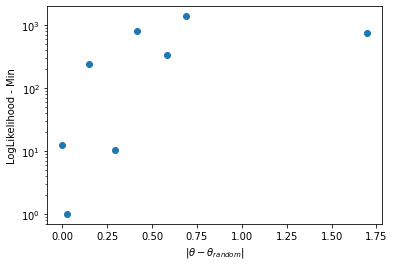

In [18]:
plt.scatter(dist,np.array(lps)-np.min(lps)+1.)
plt.ylabel('LogLikelihood - Min')
plt.xlabel(r'|$\theta-\theta_{random}$|')
plt.yscale('log')

In [19]:
import time
start = time.time()
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_very_simple(*args)
initial = theta_true + 0.05 * np.random.randn(9)
soln = minimize(nll, initial)
end = time.time()
vsp_time = end - start
print("Very Simple Model took {0:.1f} seconds".format(vsp_time))

Very Simple Model took 0.2 seconds


<ipython-input-13-5508ea45f026>:48: RuntimeWarning: invalid value encountered in add
  lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
/data0/sw/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-13-5508ea45f026>:48: RuntimeWarning: invalid value encountered in add
  lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov


In [20]:
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

Maximum likelihood estimates:
Albd = 79.578
Blbd = 0.937
Clbd = 0.271
Scatter_lbd = 0.166
rho: 0.716


In [21]:
theta_true

[5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [22]:
soln.x

array([ 5.4639723 ,  1.43362543,  0.4660078 ,  0.1632778 , 79.57839937,
        0.93700703,  0.27078264,  0.16588645,  0.71564494])

In [23]:
def logposterior_vsp(theta):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_very_simple(theta)

# Implementing Simple LogLikelihood Model

In [ ]:
import time
from multiprocessing import Pool

pool = Pool(processes=64)              # start 64 worker processes
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior_vsp, pool=pool)
start = time.time()
sampler.run_mcmc(guess, Nsamples+Nburnin)
end = time.time()
vsp_mcmc_time = end - start
print("Very Simple Model took {0:.1f} seconds".format(vsp_mcmc_time))

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likeliho

In [ ]:
flat_samples = sampler.flatchain
fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
samples = flat_samples
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
import corner

fig = corner.corner(flat_samples, truths=theta_true);